# Topic Modeling: NYC 311 Service Requests
Determining optimal number of topics using coherence scores (Elbow Method)

This notebook handles:

- Loading vectorized matrices and vectorizers from the vectorization phase.
- Determining optimal number of topics using coherence scores (elbow method).
- Applying topic modeling: LDA (with Count Matrix via Gensim) and NMF (with TF-IDF Matrix via scikit-learn).
- Evaluating models (coherence scores, top words per topic).
- Visualizing topics (pyLDAvis for LDA, word clouds for NMF topics).
- Saving models and results for the reflection/finalization phase.

We use Gensim for LDA (multicore support for large data) and coherence calculation. scikit-learn for NMF. 
Hyperparameters are tuned based on coherence scores over a range of topic numbers (5–25) to identify the optimal number using the elbow method.

## 1. Import Libraries

In [2]:
# 1. Import Libraries
import joblib
import numpy as np
import pandas as pd
from scipy.sparse import load_npz
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import LdaMulticore
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings

pyLDAvis.enable_notebook()

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="gensim.topic_coherence.direct_confirmation_measure")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="gensim.topic_coherence.indirect_confirmation_measure")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## 2. Load Vectorized Data

In [3]:
# 2. Load Vectorized Data 
tfidf_vectorizer = joblib.load('../data/processed/tfidf_vectorizer.pkl')
count_vectorizer = joblib.load('../data/processed/count_vectorizer.pkl')

tfidf_matrix = load_npz('../data/processed/tfidf_matrix.npz')
count_matrix = load_npz('../data/processed/count_matrix.npz')

tfidf_features = tfidf_vectorizer.get_feature_names_out()
count_features = count_vectorizer.get_feature_names_out()

corpus = Sparse2Corpus(count_matrix, documents_columns=False)
dictionary = Dictionary.from_corpus(corpus, id2word=dict(enumerate(count_features)))

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Count Matrix Shape: {count_matrix.shape}")
print(f"Vocabulary Size: {len(dictionary)}")

# Reconstruct tokenized text
processed_df = pd.read_csv('../data/processed/processed_complaints.csv', usecols=['processed_text'])
processed_df['processed_text'] = processed_df['processed_text'].fillna('')
analyzer = count_vectorizer.build_analyzer()
texts = [analyzer(text) for text in processed_df['processed_text']]
texts = [t for t in texts if len(t) > 0]  

print(f"Number of non-empty tokenized texts: {len(texts)}")

TF-IDF Matrix Shape: (242348, 1617)
Count Matrix Shape: (242348, 1617)
Vocabulary Size: 1617
Number of non-empty tokenized texts: 242348


## 3. Determine Optimal Number of Topics
We compute coherence scores (CV metric) for a range of topic numbers to find the optimal k.

In [4]:
# 3. Elbow Method: Find Optimal Number of Topics using Coherence (c_v)
def find_optimal_topics(start=5, end=26, step=3):
    coherence_scores = []
    models = []
    topic_range = range(start, end, step)
    
    print("Computing coherence for different number of topics...")
    for num_topics in topic_range:
        print(f"   → Training LDA with {num_topics} topics...")
        lda_model = LdaMulticore(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            passes=10,
            workers=6,
            random_state=42,
            eval_every=None
        )
        models.append(lda_model)
        
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=texts,           
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_scores.append(coherence_model.get_coherence())
    
    return models, coherence_scores, list(topic_range)

lda_models, coherence_values, topic_numbers = find_optimal_topics(5, 26, 3)

Computing coherence for different number of topics...
   → Training LDA with 5 topics...
   → Training LDA with 8 topics...
   → Training LDA with 11 topics...
   → Training LDA with 14 topics...
   → Training LDA with 17 topics...
   → Training LDA with 20 topics...
   → Training LDA with 23 topics...


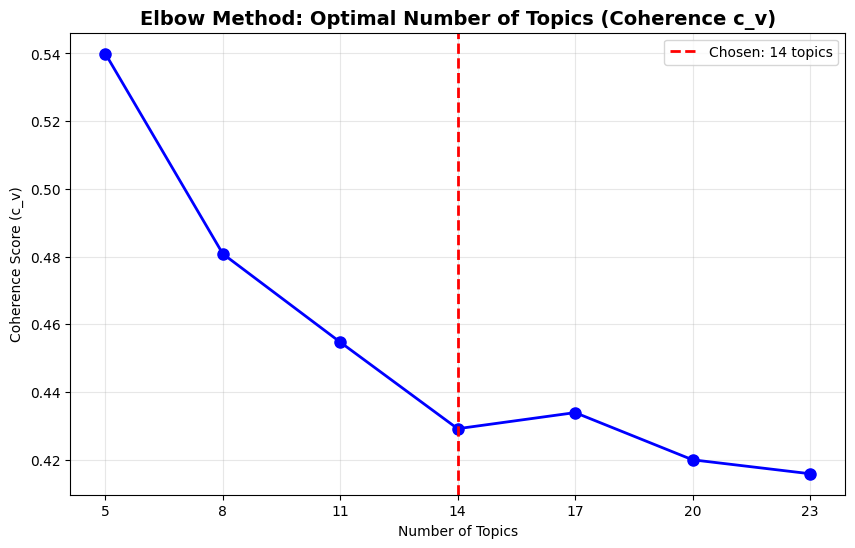


Selected optimal number of topics: 14
Coherence scores: {5: np.float64(0.5399), 8: np.float64(0.4808), 11: np.float64(0.4547), 14: np.float64(0.4291), 17: np.float64(0.4339), 20: np.float64(0.4199), 23: np.float64(0.4158)}


In [7]:
# 4. Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(topic_numbers, coherence_values, 'bo-', linewidth=2, markersize=8)
plt.title('Elbow Method: Optimal Number of Topics (Coherence c_v)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (c_v)')
plt.xticks(topic_numbers)
plt.grid(True, alpha=0.3)

# Elbow point after inspection
optimal_k = 14
plt.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Chosen: {optimal_k} topics')
plt.legend()
plt.show()

print(f"\nSelected optimal number of topics: {optimal_k}")
print("Coherence scores:", dict(zip(topic_numbers, np.round(coherence_values, 4))))

## 4. Train Final Models with Optimal Topics

### a) LDA Model

In [8]:
# 5. Train Final LDA Model with Optimal Number
final_lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=optimal_k,
    passes=20,
    iterations=200,
    random_state=42,
    workers=6
)

print(f"Final LDA model trained with {optimal_k} topics.")

Final LDA model trained with 14 topics.


### b) NMF Model

In [10]:
# 6. Train NMF with Same Number of Topics (for fair comparison)
nmf_model = NMF(
    n_components=optimal_k,
    init='nndsvd',
    random_state=42,
    max_iter=500
)
nmf_W = nmf_model.fit_transform(tfidf_matrix)
nmf_H = nmf_model.components_

print(f"NMF trained with {optimal_k} topics.")

NMF trained with 14 topics.


## 5. Evaluation

In [11]:
# 7. Display Top Words
print("\n=== LDA Topics ===")
for i in range(optimal_k):
    words = [w for w, _ in final_lda_model.show_topic(i, topn=10)]
    print(f"Topic {i+1:2d}: {', '.join(words)}")

print("\n=== NMF Topics ===")
for i in range(optimal_k):
    top_idx = nmf_H[i].argsort()[:-11:-1]
    top_words = [tfidf_features[j] for j in top_idx]
    print(f"NMF Topic {i+1:2d}: {', '.join(top_words)}")


=== LDA Topics ===
Topic  1: loud, music, party, music party, loud music, flow, heavy flow, heavy, switch, outlet
Topic  2: crosswalk, window, frame, window frame, permit, truck music, break, none, permit none, cooking
Topic  3: license, plate, license plate, use, permit, improper, parking, improper use, permit improper, parking permit
Topic  4: traffic, park, park traffic, double, double park, property, elevator, device property, device, service
Topic  5: hydrant, noise, request, construction, use, use comment, comment, noise construction, flooding, removal
Topic  6: vehicle, derelict vehicle, derelict, garbage, storage, recycling, garbage recycling, recycling storage, park vehicle, park
Topic  7: entire, bike, lane, bike lane, sighting, shower, bathtub shower, bathtub, rat, rat sighting
Topic  8: truck, car, car truck, truck horn, horn, music, odor, hit, defective, chemical
Topic  9: partial access, partial, access, light, controller, branch, sink, fall, basin sink, basin
Topic 10: 

## 6. Visualization

### a) pyLDAvis for LDA

In [13]:
pyLDAvis.enable_notebook()

In [14]:
# 8. Visualizations
# pyLDAvis
vis = gensimvis.prepare(final_lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(vis)

In [15]:
# Save to HTML for reference
pyLDAvis.save_html(vis, '../data/processed/lda_visualization.html')

### b) Word Clouds for NMF Topics

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


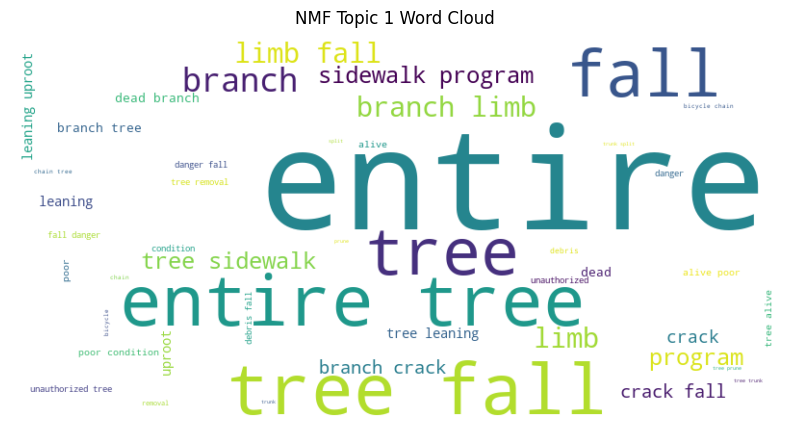

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


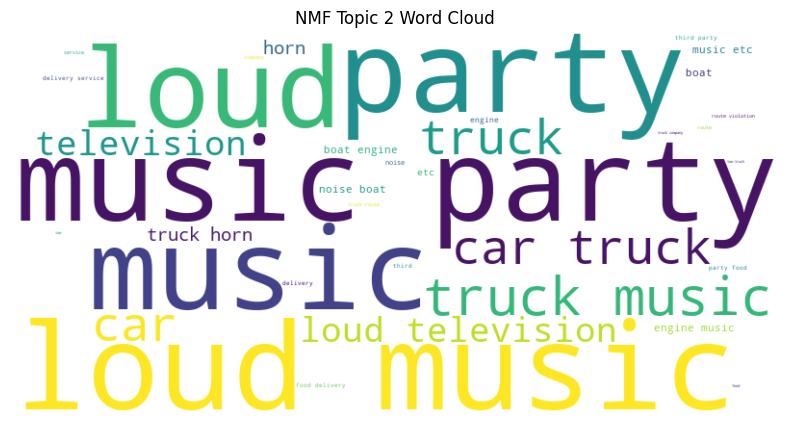

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


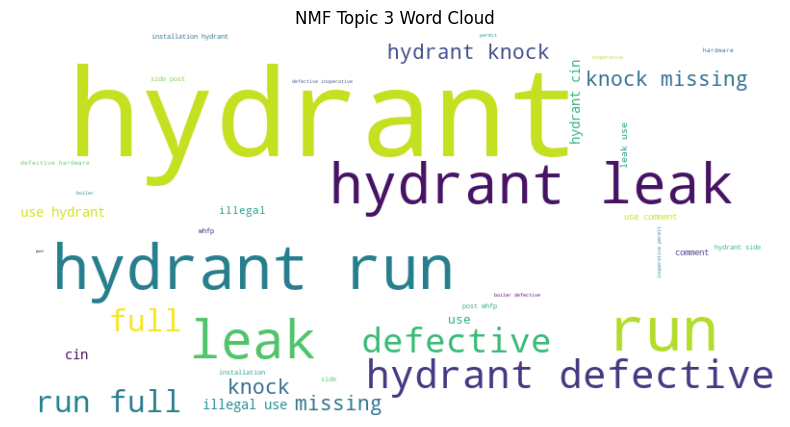

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


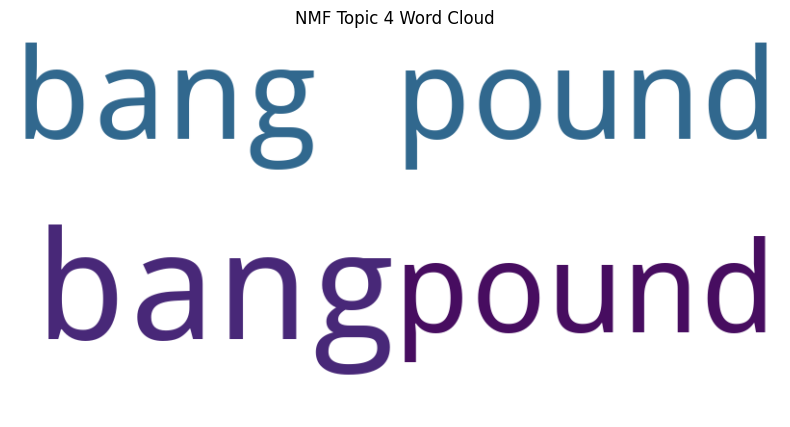

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


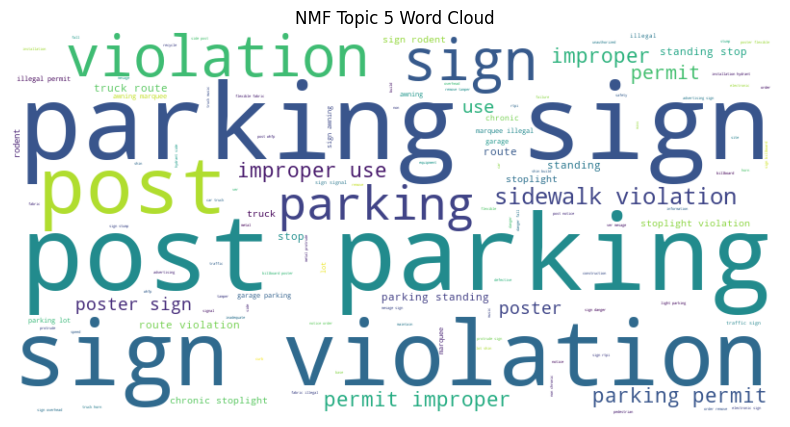

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


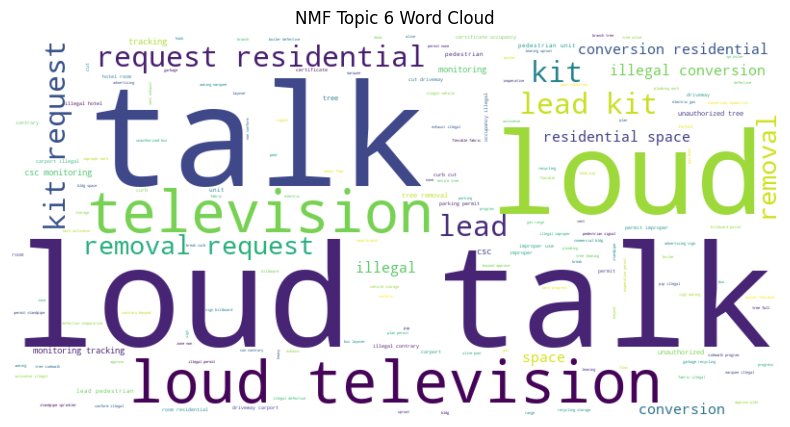

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


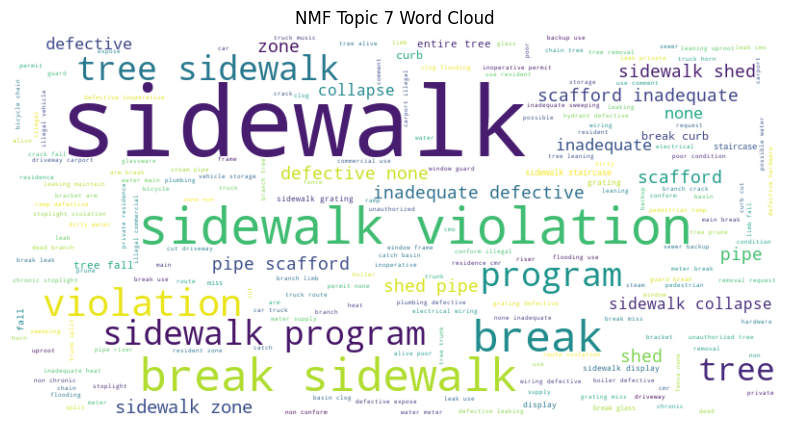

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


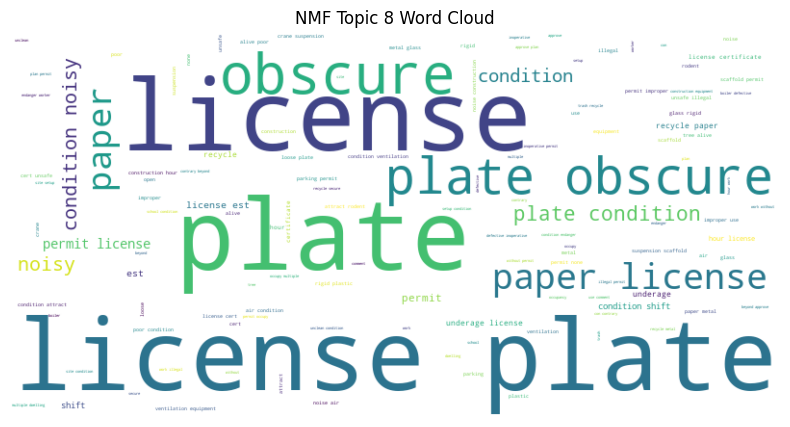

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


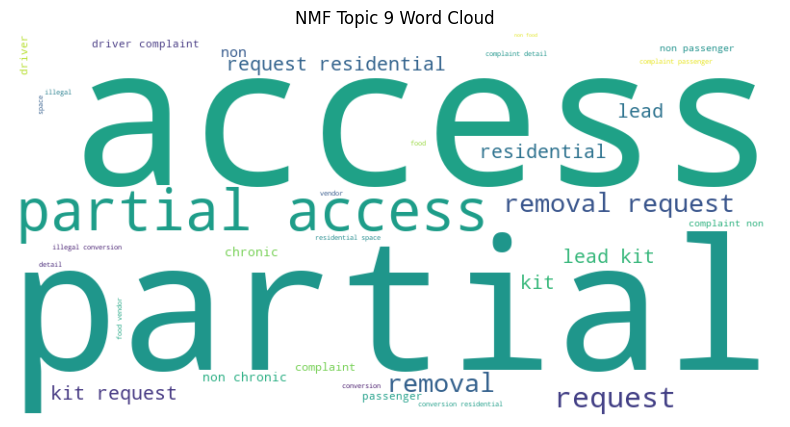

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


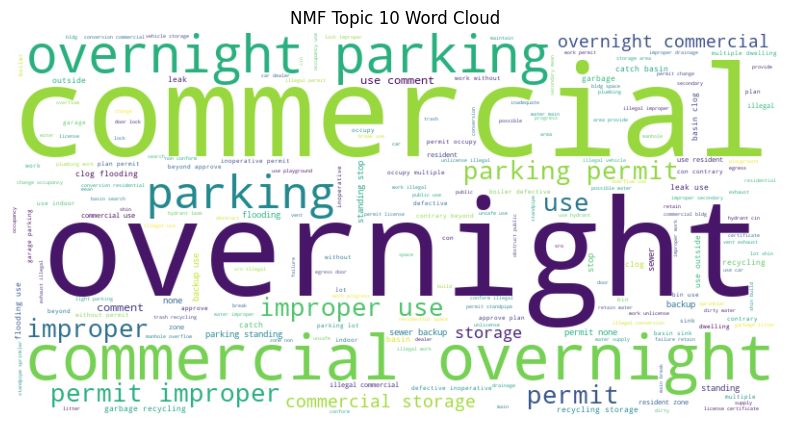

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


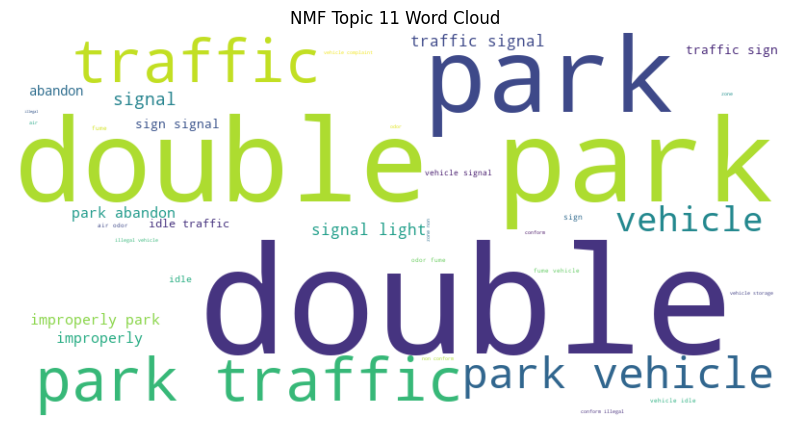

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


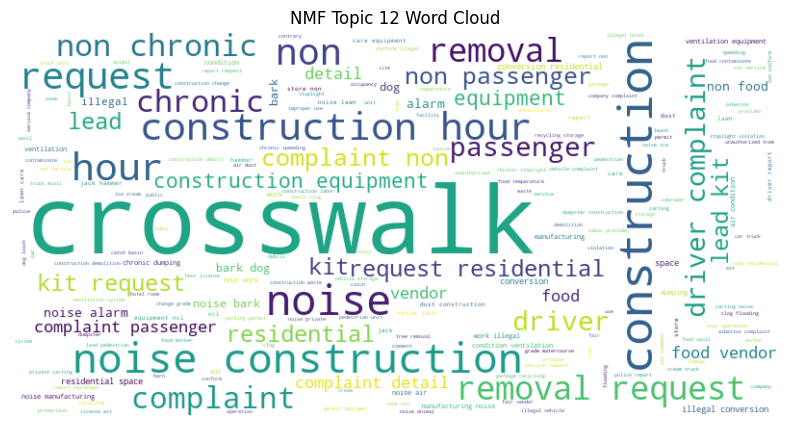

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


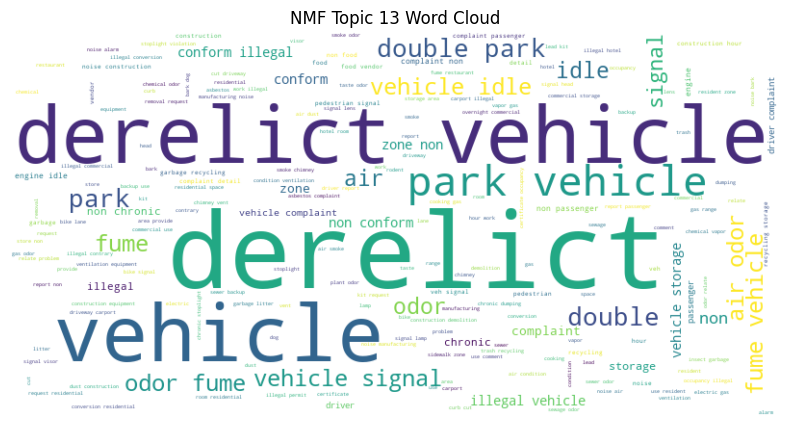

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


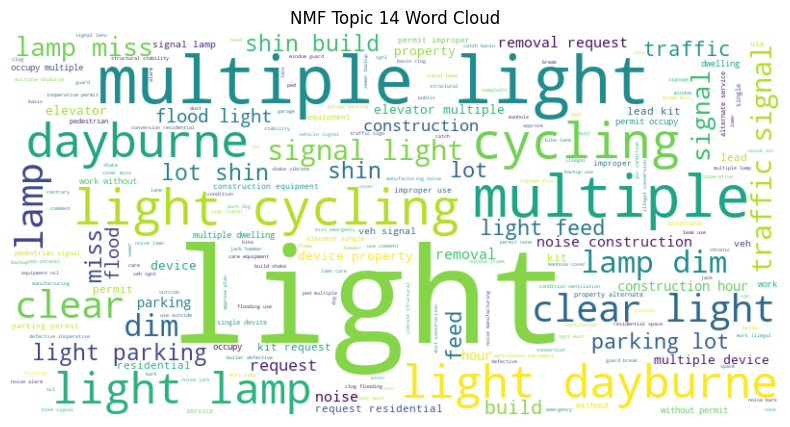

In [35]:
# NMF Word Clouds
for i in range(min(14, optimal_k)):
    wc = WordCloud(width=800, height=400, background_color='white')
    word_freq = dict(zip(tfidf_features, nmf_H[i]))
    wc.generate_from_frequencies(word_freq)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'NMF Topic {i+1} Word Cloud')
    plt.show()

## 7. Quantitative Comparison

In [20]:
# Topic Similarity (Cosine between topic-word vectors)
# Get LDA topic-word matrix (probabilities)
lda_topic_words = np.array([final_lda_model.get_topic_terms(i, topn=len(dictionary)) for i in range(final_lda_model.num_topics)])
lda_matrix = np.zeros((final_lda_model.num_topics, len(dictionary)))
for t in range(final_lda_model.num_topics):
    for word_id, prob in final_lda_model.get_topic_terms(t, topn=len(dictionary)):
        lda_matrix[t, word_id] = prob

In [22]:
# Normalize to probabilities
nmf_matrix = nmf_H / nmf_H.sum(axis=1, keepdims=True)

In [23]:
if lda_matrix.shape[0] != nmf_matrix.shape[0]:
    print("Num topics differ; computing average pairwise similarity.")
    similarities = cosine_similarity(lda_matrix, nmf_matrix)
    avg_sim = np.mean(similarities)
else:
    similarities = cosine_similarity(lda_matrix, nmf_matrix)
    avg_sim = np.mean(np.diag(similarities))  

print(f"Average Topic Similarity (LDA vs NMF): {avg_sim}")

Average Topic Similarity (LDA vs NMF): 0.04785783178782289


In [24]:
# Document-Topic Overlap (Jaccard on top topics per doc)
lda_doc_topics = [max(final_lda_model.get_document_topics(doc, minimum_probability=0), key=lambda x: x[1])[0] for doc in corpus[:10000]]  # Sample 10k
nmf_doc_topics = np.argmax(nmf_W[:10000], axis=1)  # From NMF document-topic matrix
jaccard = len(set(lda_doc_topics) & set(nmf_doc_topics)) / len(set(lda_doc_topics) | set(nmf_doc_topics))
print(f"Document-Topic Overlap (Jaccard): {jaccard}")  # Higher = better agreement

Document-Topic Overlap (Jaccard): 1.0


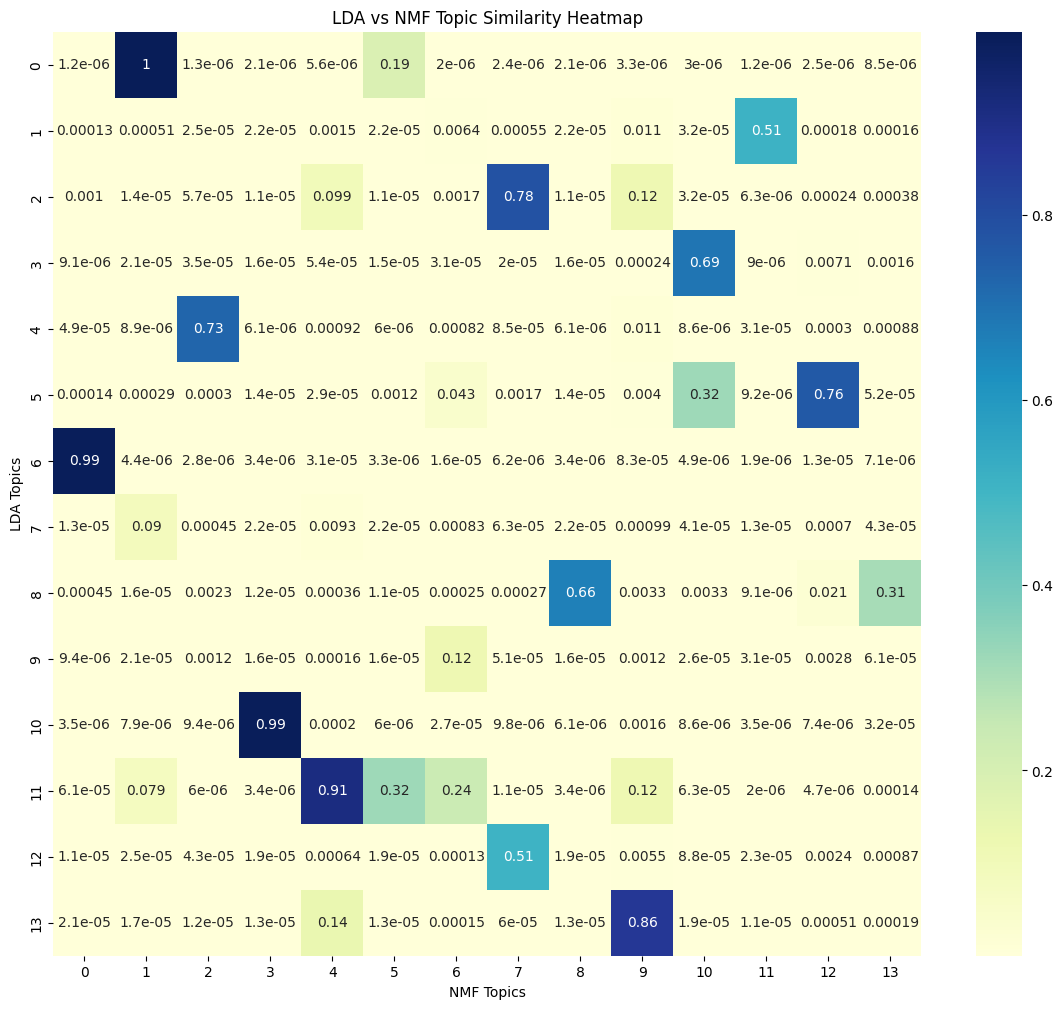

In [29]:
# Visualize Comparison (Heatmap of similarities)
plt.figure(figsize=(14, 12))
sns.heatmap(similarities, annot=True, cmap='YlGnBu')
plt.title('LDA vs NMF Topic Similarity Heatmap')
plt.xlabel('NMF Topics')
plt.ylabel('LDA Topics')
plt.show()

# Save Results

In [34]:
# 10. Save Results
joblib.dump(final_lda_model, '../data/processed/final_lda_model.joblib')
joblib.dump(nmf_model, '../data/processed/final_nmf_model.joblib')
pyLDAvis.save_html(vis, '../data/processed/lda_pyldavis.html')
